# [CDAF] Atividade 6

## Nome e matrícula
Nome: Luís Felipe Ramos Ferreira
Matrícula: 2019022553

## Referências
- [1] https://www.ecmlpkdd2019.org/downloads/paper/701.pdf
- [2] https://dtai.cs.kuleuven.be/sports/blog/player-vectors:-characterizing-soccer-players'-playing-style
- [3] https://dtai.cs.kuleuven.be/sports/player_vectors
- [4] https://github.com/TomDecroos/matplotsoccer

## Introdução
- Nessa atividade, temos implementado o "Player Vectors", método proposto em [1] para caracterizar o estilo de jogo de jogadores baseado nas localizações que realizam cada tipo de ação.
- [2] apresenta o conteúdo do paper em [1] de forma mais resumida e visual, em formato de blog.
- [3] oferece uma demo interativa com uma aplicação do método no contexto de comparar a similaridade entre jogadores.
- [4] é uma biblioteca para plotar visualizações de partidas de futebol. Além disso, ela tem uma função pronta para criar heatmaps de ações de jogadores, que é util para o nosso contexto.

## Intruções
- Para cada header abaixo do notebook, vocês devem explicar o que foi feito e à qual seção/subseção/equação de [1] ela corresponde. Justifique suas respostas.
- Além disso, vocês devem montar um diagrama do fluxo de funções/tarefas de toda a pipeline do Player Vectors abaixo. Esse diagrama deve ser enviado como arquivo na submissão do Moodle, para além deste notebook.

### Carregando os dados

Aqui foi feito o carregamento dos dados necessários para os cálculos que serão feitos posteriormente. É uma parte simples, que se refere à seção 2 do artigo, de forma geral.

In [26]:
import numpy as np
import pandas as pd

In [27]:
def load_matches(path):
    matches = pd.read_json(path_or_buf=path)
    # as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
    team_matches = []
    for i in range(len(matches)):
        team_match = pd.DataFrame(matches.loc[i, "teamsData"]).T
        team_match["matchId"] = matches.loc[i, "wyId"]
        team_matches.append(team_match)
    team_matches = pd.concat(team_matches).reset_index(drop=True)

    return matches, team_matches

In [28]:
def get_position(x):
    return x["name"]


def load_players(path):
    players = pd.read_json(path_or_buf=path)
    players["player_name"] = players["firstName"] + " " + players["lastName"]
    players["role"] = players["role"].apply(get_position)
    players = players[["wyId", "player_name", "role"]].rename(
        columns={"wyId": "player_id"}
    )

    return players

In [29]:
def load_events(path):
    events = pd.read_json(path_or_buf=path)
    # pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
    events = events.rename(
        columns={
            "id": "event_id",
            "eventId": "type_id",
            "subEventId": "subtype_id",
            "teamId": "team_id",
            "playerId": "player_id",
            "matchId": "game_id",
        }
    )
    events["milliseconds"] = events["eventSec"] * 1000
    events["period_id"] = events["matchPeriod"].replace({"1H": 1, "2H": 2})

    return events

In [30]:
def load_minutes_played_per_game(path):
    minutes = pd.read_json(path_or_buf=path)
    minutes = minutes.rename(
        columns={
            "playerId": "player_id",
            "matchId": "game_id",
            "teamId": "team_id",
            "minutesPlayed": "minutes_played",
        }
    )
    minutes = minutes.drop(["shortName", "teamName", "red_card"], axis=1)

    return minutes

In [31]:
leagues = ["England", "Spain"]
events = {}
matches = {}
team_matches = {}
game_minutes = {}
for league in leagues:
    path = f"../data/atv03/matches/matches_{league}.json"
    matches[league], team_matches[league] = load_matches(path)
    path = f"../data/atv03/events/events_{league}.json"
    events[league] = load_events(path)
    path = f"../data/atv03/minutes_played/minutes_played_per_game_{league}.json"
    game_minutes[league] = load_minutes_played_per_game(path)

In [32]:
path = "../data/atv03/players/players.json"
players = load_players(path)
players["player_name"] = players["player_name"].str.decode("unicode-escape")

In [33]:
def calculate_minutes_per_season(minutes_per_game):
    minutes_per_season = minutes_per_game.groupby("player_id", as_index=False)[
        "minutes_played"
    ].sum()

    return minutes_per_season

### SPADL

Neste *header*, é feita a conversão dos dados carregados anteriormente para o formato padronizado SPADL, de modo que este formato é o mais utilizado e o de melhor usabilidade para realizar os cálculos necessários. Mais uma vez, se refere à seção 2 do artigo, especificamente da parte 2.1 onde o formato SPADL é definido.

In [34]:
from tqdm import tqdm
import socceraction.spadl as spd

In [35]:
def spadl_transform(events, team_matches):
    spadl = []
    game_ids = events.game_id.unique().tolist()
    for g in tqdm(game_ids):
        match_events = events.loc[events.game_id == g]
        match_home_id = team_matches.loc[
            (team_matches.matchId == g) & (team_matches.side == "home"), "teamId"
        ].values[0]
        match_actions = spd.wyscout.convert_to_actions(
            events=match_events, home_team_id=match_home_id
        )
        match_actions = spd.play_left_to_right(
            actions=match_actions, home_team_id=match_home_id
        )
        match_actions = spd.add_names(match_actions)
        spadl.append(match_actions)
    spadl = pd.concat(spadl).reset_index(drop=True)

    return spadl

In [36]:
# dados de eventos das ligas formatados para SPADL foram salvos para acelerar os processos
spadl = {}
for league in leagues:
    # spadl[league] = spadl_transform(events=events[league], team_matches=team_matches[league])
    spadl[league] = pd.read_json(f"../data/atv05/spadl_{league}.json")

### Construção de Heatmaps

Neste *header*, é inicializado de fato o cálculo das métricas necessárias para a construção dos *player vectors*. Especificamente falando desta parte, é realizada a construção dos *heatmaps* de cada jogador para cada um dos tipos de ações desejados. Como pode-se notar na definição da função *construct_heatmaps*, para ações do tipo passe, são construídos *heatmaps* para posições de início e fim da ação, assim como foi definido no artigo. Os *heatmaps* em questão são fundamentais para a caracterização dos jogadores por meio da métrica proposta. Por meio deles, é possível calcular e generalizar para cada jogador as frequências em determinadas posições no campo que ele performa cada tipo de ação.

As computações realizadas aqui são correspondentes às seções 3 e 4 (4.2 principalmente) do artigo, em que são discutidos, respectivamente, como definir e avaliar os tipos de jogo e como construir os vetores de jogadores.

In [37]:
import scipy
import matplotsoccer as mps

In [38]:
def construct_heatmaps(spadl, season_minutes, action_type):
    heatmaps = {}
    if action_type == "pass":
        heatmaps["start"] = {}
        heatmaps["end"] = {}
    for player_id in tqdm(season_minutes["player_id"].tolist()):
        mask = (spadl["player_id"] == player_id) & (spadl["type_name"] == action_type)
        player_actions = spadl[mask]
        if action_type != "pass":
            heatmaps[player_id] = mps.count(
                x=player_actions["start_x"], y=player_actions["start_y"], n=25, m=16
            )
            heatmaps[player_id] *= (
                90
                / season_minutes[season_minutes["player_id"] == player_id][
                    "minutes_played"
                ].values[0]
            )
            heatmaps[player_id] = scipy.ndimage.gaussian_filter(heatmaps[player_id], 1)
        else:
            heatmaps["start"][player_id] = mps.count(
                x=player_actions["start_x"], y=player_actions["start_y"], n=25, m=16
            )
            heatmaps["start"][player_id] *= (
                90
                / season_minutes[season_minutes["player_id"] == player_id][
                    "minutes_played"
                ].values[0]
            )
            heatmaps["start"][player_id] = scipy.ndimage.gaussian_filter(
                heatmaps["start"][player_id], 1
            )
            heatmaps["end"][player_id] = mps.count(
                x=player_actions["end_x"], y=player_actions["end_y"], n=25, m=16
            )
            heatmaps["end"][player_id] *= (
                90
                / season_minutes[season_minutes["player_id"] == player_id][
                    "minutes_played"
                ].values[0]
            )
            heatmaps["end"][player_id] = scipy.ndimage.gaussian_filter(
                heatmaps["end"][player_id], 1
            )

    return heatmaps

In [39]:
season_minutes = {}
for league in leagues:
    season_minutes[league] = calculate_minutes_per_season(
        minutes_per_game=game_minutes[league]
    )
    mask = (season_minutes[league]["minutes_played"] >= 900) & (
        season_minutes[league]["player_id"].isin(
            players.loc[players["role"] != "Goalkeeper", "player_id"]
        )
    )
    season_minutes[league] = season_minutes[league][mask]

In [40]:
action_types = ["shot", "pass", "cross", "dribble"]
heatmaps = {}
for league in leagues:
    heatmaps[league] = {}
    for at in action_types:
        heatmaps[league][at] = construct_heatmaps(
            spadl=spadl[league], season_minutes=season_minutes[league], action_type=at
        )

100%|██████████| 324/324 [00:14<00:00, 22.56it/s]


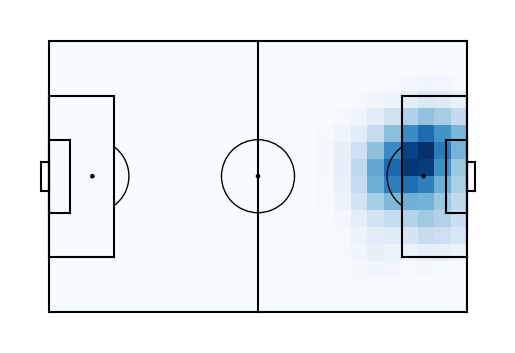

<Axes: >

In [41]:
mps.heatmap(heatmaps["Spain"]["shot"][3359])

### Comprimindo heatmaps para vetores

Aqui, é computada a compressão dos *heatmaps* calculados anteriormente em vetores unidimensionais. Essa parte é importante para que esses vetores gerados para cada jogador em cada ação possam ser agrupados para análise. Mais especificamente, como definido na seção 4.3 do artigo, para cada tipo de ação desejado, é construída uma matriz em que cada umas das K colunas é um vetor (*heatmap* comprimido) de cada um dos jogadores.

No enatno, a construção dessa matriz é feita apenas posteriormente, e neste *header* é feita apenas a compressão dos *heatmaps*, como definido na seção 4.3.

In [42]:
def heatmaps_to_vectors(heatmaps, action_type):
    if action_type != "pass":
        vectorized_heatmaps = np.array(
            [heatmaps[player_id].reshape(-1) for player_id in heatmaps.keys()]
        )
    else:
        vectorized_heatmaps = np.array(
            [
                np.concatenate(
                    [
                        heatmaps["start"][player_id].reshape(-1),
                        heatmaps["end"][player_id].reshape(-1),
                    ]
                )
                for player_id in heatmaps["start"].keys()
            ]
        )

    return vectorized_heatmaps

In [43]:
vectorized_heatmaps = {}
for league in leagues:
    vectorized_heatmaps[league] = {}
    for act_type in action_types:
        vectorized_heatmaps[league][act_type] = heatmaps_to_vectors(
            heatmaps=heatmaps[league][act_type], action_type=act_type
        )

### NMF

Aqui é computada a fatoração não negativa da matriz M de cada tipo de ação que será construída a partir dos vetores comprimidos criados anteriormente. A fatoração não negativa é feita para que sejam criadas duas matrizes W e H, tais que WH é aproximdamente M, que possuem componentes importantes para análise geral das ações e dos jogadores que as performam.

Mais especificamente, as colunas de W são componentes que representam agrupamentos espaciais da ação analisada, e as linhas em H são versões comprimidas dos *heatmaps* originalmente presentes em M. De forma geral, com essa fatoração, é possível reagrupar características e classificar as ações em diferentes conjuntos de acordo com as posições em que elas acontecem no campo.

Essa seção é discutida na seção 4 do artigo, mais especificamente na subseção 4.3, de tal modo que a equação (1) é a equação citada sobre fatoração de matrizes não negativas.

In [44]:
from sklearn.decomposition import NMF

In [45]:
def nmf_decomposition(vectorized_heatmaps, n_components):
    nmf = NMF(n_components=n_components, init="nndsvda", random_state=0)
    nmf.fit(vectorized_heatmaps)

    return nmf

In [46]:
n_components = {"shot": 4, "pass": 5, "cross": 4, "dribble": 5}
concat_vectors = {}
nmfs = {}
for act_type in action_types:
    concat_vectors[act_type] = np.concatenate(
        [
            vectorized_heatmaps["England"][act_type],
            vectorized_heatmaps["Spain"][act_type],
        ]
    )
    nmfs[act_type] = nmf_decomposition(
        vectorized_heatmaps=concat_vectors[act_type],
        n_components=n_components[act_type],
    )

### Reconstruction Evaluation

Neste *header*, é avaliada a fatoração não negativa das matrizes de cada tipo de ação, por meio da análise das métricas de avaliação de reconstrução disponibilizadas pelo próprio *scikit-learn*. Com estes cálculos, podemos avaliar quão eficiente foi a decomposição das matrizes originais, permitindo saber se a perda de informação no processo foi grande.

In [47]:
for act_type in action_types:
    print("{} Reconstruction evaluation\n".format(act_type))
    print(
        "Reconstruction error from NMF object: {}".format(
            nmfs[act_type].reconstruction_err_
        )
    )
    reconst_vectors = np.dot(
        nmfs[act_type].components_.T,
        nmfs[act_type].transform(concat_vectors[act_type]).T,
    ).T
    reconst_error = np.sqrt(np.sum((concat_vectors[act_type] - reconst_vectors) ** 2))
    print("Manual reconstruction error: {}".format(reconst_error))
    print(
        "Mean reconstruction error: {}".format(
            reconst_error / (concat_vectors[act_type].shape[1])
        )
    )
    print("--------------------------------\n")

shot Reconstruction evaluation

Reconstruction error from NMF object: 1.322487922632152
Manual reconstruction error: 1.322487918480089
Mean reconstruction error: 0.0033062197962002225
--------------------------------

pass Reconstruction evaluation

Reconstruction error from NMF object: 28.187148371523932
Manual reconstruction error: 28.187148122559634
Mean reconstruction error: 0.035233935153199544
--------------------------------

cross Reconstruction evaluation

Reconstruction error from NMF object: 2.3365384800195814
Manual reconstruction error: 2.3365384458665375
Mean reconstruction error: 0.005841346114666344
--------------------------------

dribble Reconstruction evaluation

Reconstruction error from NMF object: 4.0057846934624015
Manual reconstruction error: 4.005784678627454
Mean reconstruction error: 0.010014461696568635
--------------------------------



### Deanonymization Evaluation

Neste *header*, é feito a avaliação do modelo por meio da análise da desanonimização de jogadores, isto é, é criado um modelo a partir dos dados de eventos da primeira metade da base de dados, ordenada pela data dos jogos, e sua performance é avaliada utilizando a segunda metade como teste. Isto é feito para que seja visto se o próprio jogadores J irá aparecer nos dados de teste/predição como um dos jogadores que mais se assemelham a ele mesmo, criado na base de treino. 

Uma vez que a métrica de similaridade de jogadores por meio da distância de *Player Vector* gera uma lista de jogadores mais similares em forma de jogo, é avaliado não só se o jogador J apareceu como o que mais se aproxima dele mesmo, mas avaliado também quantas vezes ele aparecer entre os 3, 5 ou 10 jogadores que mais se aproximam dele, assim como também é avaliado o erro dessa medição.

Tal abordagem é importante pois o modelo não é perfeito, e raramente um jogador será perfeitamente classificado como o mais próximo dele mesmo. No entanto, analisando os N mais próximos jogadores e checando a existência do próprio jogador nessa lista, podemos ter uma visão mais detalhada de quão bem o classificar performa na caracterização do estilo de jogo dos atletas estudados.

Os conceitos abordados nessa parte do código são tratados principalmente na seção 5.4 do artigo, embora o conceito seja discutido em outras seções, como a 3. Em suma, como dito no próprio artigo, a métrica é crucial para avalair a performance do modelo. Se a maioria dos jogadores aparecer no topo de seus *rankings* de similaridade, então o modelo é satisfatório. Se a maioria dos jogadores não aparece perto do topo de seus próprios *rankings*, o modelo é falho.

In [48]:
matches_1st = {}
matches_2nd = {}
spadl_1st = {}
spadl_2nd = {}
season_minutes_1st = {}
season_minutes_2nd = {}
for league in leagues:
    matches[league] = matches[league].sort_values(by="dateutc").reset_index(drop=True)
    matches_1st[league] = (
        matches[league].loc[: int(len(matches[league]) / 2) - 1, "wyId"].values.tolist()
    )
    matches_2nd[league] = (
        matches[league].loc[int(len(matches[league]) / 2) :, "wyId"].values.tolist()
    )
    season_minutes_1st[league] = calculate_minutes_per_season(
        game_minutes[league][game_minutes[league]["game_id"].isin(matches_1st[league])]
    )
    season_minutes_2nd[league] = calculate_minutes_per_season(
        game_minutes[league][game_minutes[league]["game_id"].isin(matches_2nd[league])]
    )
    season_minutes_1st[league] = season_minutes_1st[league][
        season_minutes_1st[league]["minutes_played"] >= 900
    ]
    season_minutes_2nd[league] = season_minutes_2nd[league][
        season_minutes_2nd[league]["minutes_played"] >= 900
    ]
    season_minutes_1st[league] = season_minutes_1st[league][
        season_minutes_1st[league]["player_id"].isin(
            season_minutes_2nd[league]["player_id"]
        )
    ]
    season_minutes_2nd[league] = season_minutes_2nd[league][
        season_minutes_2nd[league]["player_id"].isin(
            season_minutes_1st[league]["player_id"]
        )
    ]
    mask_1st = (spadl[league]["game_id"].isin(matches_1st[league])) & (
        spadl[league]["player_id"].isin(season_minutes_1st[league]["player_id"])
    )
    spadl_1st[league] = spadl[league][mask_1st]
    mask_2nd = (spadl[league]["game_id"].isin(matches_2nd[league])) & (
        spadl[league]["player_id"].isin(season_minutes_2nd[league]["player_id"])
    )
    spadl_2nd[league] = spadl[league][mask_2nd]

In [49]:
heatmaps_1st = {}
heatmaps_2nd = {}
for league in leagues:
    heatmaps_1st[league] = {}
    heatmaps_2nd[league] = {}
    for at in action_types:
        heatmaps_1st[league][at] = construct_heatmaps(
            spadl=spadl_1st[league],
            season_minutes=season_minutes_1st[league],
            action_type=at,
        )
        heatmaps_2nd[league][at] = construct_heatmaps(
            spadl=spadl_2nd[league],
            season_minutes=season_minutes_2nd[league],
            action_type=at,
        )

100%|██████████| 154/154 [00:02<00:00, 74.41it/s]


In [50]:
vectorized_heatmaps_1st = {}
vectorized_heatmaps_2nd = {}
for league in leagues:
    vectorized_heatmaps_1st[league] = {}
    vectorized_heatmaps_2nd[league] = {}
    for act_type in action_types:
        vectorized_heatmaps_1st[league][act_type] = heatmaps_to_vectors(
            heatmaps=heatmaps_1st[league][act_type], action_type=act_type
        )
        vectorized_heatmaps_2nd[league][act_type] = heatmaps_to_vectors(
            heatmaps=heatmaps_2nd[league][act_type], action_type=act_type
        )

In [51]:
def coefficients_transform(vectorized_heatmaps, nmf):
    return nmf.transform(vectorized_heatmaps)

In [52]:
vectorized_coefs_1st = {}
vectorized_coefs_2nd = {}
for league in leagues:
    vectorized_coefs_1st[league] = {}
    vectorized_coefs_2nd[league] = {}
    for act_type in action_types:
        vectorized_coefs_1st[league][act_type] = coefficients_transform(
            vectorized_heatmaps=vectorized_heatmaps_1st[league][act_type],
            nmf=nmfs[act_type],
        )
        vectorized_coefs_2nd[league][act_type] = coefficients_transform(
            vectorized_heatmaps=vectorized_heatmaps_2nd[league][act_type],
            nmf=nmfs[act_type],
        )

In [53]:
player_vectors_1st = {}
player_vectors_2nd = {}
for league in leagues:
    player_vectors_1st[league] = np.concatenate(
        [vectorized_coefs_1st[league][act_type] for act_type in action_types], axis=1
    )
    player_vectors_2nd[league] = np.concatenate(
        [vectorized_coefs_2nd[league][act_type] for act_type in action_types], axis=1
    )

In [54]:
player_vectors_1st = np.concatenate([player_vectors_1st[league] for league in leagues])
player_vectors_2nd = np.concatenate([player_vectors_2nd[league] for league in leagues])

In [55]:
player_ids = []
for league in leagues:
    player_ids += list(heatmaps_1st[league]["shot"].keys())

In [56]:
from sklearn.metrics import pairwise_distances

In [57]:
D = pairwise_distances(player_vectors_1st, player_vectors_2nd, metric="manhattan")

# sort each row
# k_d = np.sort(D, axis=1)
# sort each row and replace distances by index
k_i = np.argsort(D, axis=1)
# replace indices by player ids
p_i = np.take(player_ids, k_i, axis=0)

rs = np.argmax(
    np.array([p_i[i, :] == player_ids[i] for i in range(p_i.shape[0])]), axis=1
)


def mean_reciprocal_rank(rs):
    return np.mean(1.0 / (rs + 1))


def top_k(rs, k):
    return (rs < k).sum() / len(rs)


mrr = mean_reciprocal_rank(rs)
top1 = top_k(rs, 1)
top3 = top_k(rs, 3)
top5 = top_k(rs, 5)
top10 = top_k(rs, 10)

In [58]:
print("Top 1 = {}%".format(round(top1 * 100, 1)))
print("Top 3 = {}%".format(round(top3 * 100, 1)))
print("Top 5 = {}%".format(round(top5 * 100, 1)))
print("Top 10 = {}%".format(round(top10 * 100, 1)))
print("MRR = {}".format(round(mrr, 3)))

Top 1 = 38.3%
Top 3 = 61.4%
Top 5 = 70.5%
Top 10 = 82.2%
MRR = 0.533


### Explore Similar Players

Neste *header*, são calculados os coeficientes e, posteriormente, os *Player Vectors* para cada um dos jogadores desejados. Como definido no artigo, o vetor V de um jogador P é a concatenação dos vetores comprimidos dele (computados durante o processo de fatoração não negativa) para cada uma das ações relevantes para análise. Após essa etapa, são calculadas as distâncias entre os jogadores de acordo com os vetores definidos para cada um deles. A métrica de distância utilizada é a distância *Manhattan*, uma vez que ela se mostrou ter um resultado melhor de classificação.

Os cálculos realizados nesta parte são abordados principalmente nas seções 4.3 e 4.4 do artigo, enquanto são discutidas nas seções subsequentes como a seção 5.

In [59]:
vectorized_coefs = {}
for league in leagues:
    vectorized_coefs[league] = {}
    for act_type in action_types:
        vectorized_coefs[league][act_type] = coefficients_transform(
            vectorized_heatmaps=vectorized_heatmaps[league][act_type],
            nmf=nmfs[act_type],
        )

In [60]:
player_vectors = {}
for league in leagues:
    player_vectors[league] = np.concatenate(
        [vectorized_coefs[league][act_type] for act_type in action_types], axis=1
    )

In [61]:
player_vectors = np.concatenate([player_vectors[league] for league in leagues])

In [62]:
player_ids = []
for league in leagues:
    player_ids += list(heatmaps[league]["shot"].keys())

In [63]:
D = pairwise_distances(player_vectors, player_vectors, metric="manhattan")
# sort each row
# k_d = np.sort(D, axis=1)
# sort each row and replace distances by index
k_i = np.argsort(D, axis=1)
# replace indices by player ids
p_i = np.take(player_ids, k_i, axis=0)

In [64]:
similar_players = pd.DataFrame(
    data=p_i[:, :11],
    columns=["player_id"] + ["{}th_similar".format(i) for i in range(1, 11)],
)

In [65]:
players = players[players["player_id"].isin(similar_players["player_id"])].reset_index(
    drop=True
)

In [66]:
id_to_name = {}
for i in range(len(players)):
    id_to_name[players.loc[i, "player_id"]] = players.loc[i, "player_name"]

In [67]:
similar_players = similar_players.replace(id_to_name)

In [74]:
similar_players.head(10)

,player_id,1th_similar,2th_similar,3th_similar,4th_similar,5th_similar,6th_similar,7th_similar,8th_similar,9th_similar,10th_similar
0,Toby Alderweireld,Aïssa Mandi,David López Silva,Raphaël Varane,Gerard Piqué Bernabéu,Aritz Elustondo Irribaria,Unai Núñez Gestoso,Ezequiel Marcelo Garay,Jack Stephens,Facundo Sebastián Roncaglia,Laurent Koscielny
1,Jan Vertonghen,Samuel Yves Umtiti,Zouhair Feddal,Íñigo Martínez Berridi,Wesley Hoedt,Clément Lenglet,Aymeric Laporte,Pedro Bigas Rigo,Anaitz Arbilla Zabala,Sergio Ramos García,Antonio Rüdiger
2,Christian Dannemann Eriksen,Mesut Özil,Kevin De Bruyne,Henrikh Mkhitaryan,Jesse Lingard,Francesc Fàbregas i Soler,Joan Jordán Moreno,Aaron Ramsey,Alex Pritchard,Paul Pogba,Erik Lamela
3,Ragnar Klavan,Andreu Fontàs Prat,Pedro Bigas Rigo,Thomas Vermaelen,Víctor Ruíz Torre,Sergio Ramos García,Jeison Fabián Murillo Cerón,Alfie Mawson,Clément Lenglet,Zouhair Feddal,Aymeric Laporte
4,Johann Berg Guðmunds­son,Matt Ritchie,Andros Townsend,David Remeseiro Salgueiro,Julián Omar Ramos Suárez,Theo Walcott,Markel Susaeta Laskurain,Ibai Gómez Pérez,Michail Antonio,Aaron Lennon,Sergio Gontán Gallardo
5,Erik Pieters,Antonio Manuel Luna Rodríguez,Rubén Duarte Sánchez,Kieran Gibbs,Paul Dummett,Charlie Taylor,Markus Suttner,Dani Castellano Betancor,Gaëtan Bong Songo,Enric Saborit Teixidor,Fernando Navarro i Corbacho
6,Georginio Wijnaldum,Víctor Camarasa Ferrando,Wayne Rooney,Mikel Rico Moreno,Pedro Mba Obiang Avomo,Mikel Merino Zazón,David Zurutuza Veillet,Grzegorz Krychowiak,Daniel García Carrillo,Idrissa Gana Gueye,Nemanja Radoja
7,Terence Kongolo,Paul Dummett,Rubén Duarte Sánchez,Fernando Navarro i Corbacho,Raúl García Carnero,Lucas Hernández Pi,Erik Pieters,Antonio Manuel Luna Rodríguez,Diego González Polanco,Dani Castellano Betancor,Charlie Taylor
8,Bruno Martins Indi,Guillermo Alfonso Maripán Loaysa,Angelo Obinze Ogbonna,Christopher Schindler,Dimitrios Siovas,Bruno González Cabrera,Christian Kabasele,Ahmed Hegazy,José Manuel Rodríguez Benito,Juan Torres Ruiz,Jonny Evans
9,Daryl Janmaat,Marc Navarro Ceciliano,Tom Smith,Roberto José Rosales Altuve,Pedro López Muñoz,Joel Ward,Rubén Peña Jiménez,Cédric Ricardo Alves Soares,Pablo Maffeo Becerra,Míchel Macedo Rocha Machado,Javier López Rodríguez
